In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import os
import joblib
import datetime as dt
import inspect
import logging

# Data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "svg"
pio.kaleido.scope.default_format = "svg"
from pandas.plotting import lag_plot
from IPython.display import display, HTML
%matplotlib inline

# Statistics and math
import math
import scipy.stats as stats
from scipy.stats import zscore
from scipy import signal
import statsmodels.api as sm
import statsmodels.tsa as smt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, acf, pacf, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.holtwinters as hw
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pymannkendall as mk
from pykalman import KalmanFilter

# Preprocessing and feature engineering
from sklearn.preprocessing import (
    QuantileTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
)
from tsfresh import extract_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split

# Model selection and evaluation
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, TimeSeriesSplit
)
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error, mean_absolute_scaled_error
)

# Machine learning models
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from tslearn.svm import TimeSeriesSVR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import torch
from torch import nn
import torch.nn as nn
from torch.optim import Adam
from pmdarima import auto_arima, ARIMA as PMDARIMA_ARIMA
from hcrystalball.wrappers import ProphetWrapper
import skorch
from skorch import NeuralNetRegressor
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter, ForecastingSkoptSearchCV
import torch.optim as optim
import torch.utils.data as data

# Pipeline and transformations
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# General
from sklearn.base import clone
from sklearn import set_config

In [2]:
# Other configurations
set_config(transform_output="pandas")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Loading the Data

In [3]:
# Load the data
df = pd.read_csv('AMZN_data.csv', parse_dates=['date'], index_col=['date'])

In [4]:
# View the data - head
df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,261.40,265.25,260.56,261.95,3879078,AMZN
2013-02-11,263.20,263.25,256.60,257.21,3403403,AMZN
2013-02-12,259.19,260.16,257.00,258.70,2938660,AMZN
2013-02-13,261.53,269.96,260.30,269.47,5292996,AMZN
2013-02-14,267.37,270.65,265.40,269.24,3462780,AMZN


In [5]:
# View the data - tail
df.tail()

,open,high,low,close,volume,Name
date,,,,,,
2018-02-01,1445.00,1459.88,1385.14,1390.00,9113808,AMZN
2018-02-02,1477.39,1498.00,1414.00,1429.95,11125722,AMZN
2018-02-05,1402.62,1458.98,1320.72,1390.00,11494985,AMZN
2018-02-06,1361.46,1443.99,1351.79,1442.84,11066819,AMZN
2018-02-07,1449.00,1460.99,1415.15,1416.78,7162741,AMZN


# Manipulating the Data

In [6]:
# Remove Name column
df.drop(columns=['Name'], inplace=True)
df.head()

,open,high,low,close,volume
date,,,,,
2013-02-08,261.40,265.25,260.56,261.95,3879078
2013-02-11,263.20,263.25,256.60,257.21,3403403
2013-02-12,259.19,260.16,257.00,258.70,2938660
2013-02-13,261.53,269.96,260.30,269.47,5292996
2013-02-14,267.37,270.65,265.40,269.24,3462780


# Exploring the Data

In [7]:
# Get quick view of data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1259 non-null   float64
 1   high    1259 non-null   float64
 2   low     1259 non-null   float64
 3   close   1259 non-null   float64
 4   volume  1259 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [8]:
# Get shape and size
print(f'There are {df.shape[0]} rows in the dataset')
print(f'There are {df.shape[1]} columns in the dataset')
print(f'The size of the dataset is: {df.size}')

There are 1259 rows in the dataset
There are 5 columns in the dataset
The size of the dataset is: 6295


In [9]:
# View first date, last date, and timespan
first_date = df.index.min()
last_date = df.index.max()
timespan_days = (last_date - first_date).days
timespan_years = timespan_days / 365.25

print(f'The first date is: {first_date}\nThe last date is: {last_date}')
print(f'The timespan for the dataset is {timespan_years:.2f} years')

The first date is: 2013-02-08 00:00:00
The last date is: 2018-02-07 00:00:00
The timespan for the dataset is 5.00 years


## Descriptive Statistics

In [10]:
# Descriptive statistics for each column
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
open,1259.00,576.87,282.50,248.94,325.87,506.00,777.62,1477.39
high,1259.00,582.02,284.42,252.93,329.48,512.33,781.84,1498.00
low,1259.00,571.11,280.22,245.75,322.18,495.64,770.72,1450.04
close,1259.00,576.88,282.50,248.23,325.80,503.82,777.42,1450.89
volume,1259.00,3730465.47,2166505.71,1092970.00,2511165.00,3144719.00,4220246.50,23856060.00


## Initial Visualizations

In [11]:
# Function to plot a line plot for a column
def plot_column_lineplot(df, var):
    """
    Plot a line plot for a column in the DataFrame.
    """
    color_palette = sns.color_palette()
    plt.style.use('fivethirtyeight')
    
    plt.figure(figsize=(8, 4))
    plt.grid(True)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel(f'{var.capitalize()}', labelpad=15)
    plt.plot(df[var], color=color_palette[2])
    plt.title(f'Amazon {var.capitalize()} (2013 - 2018)', pad=15)
    plt.xticks(rotation=35)
    plt.show()

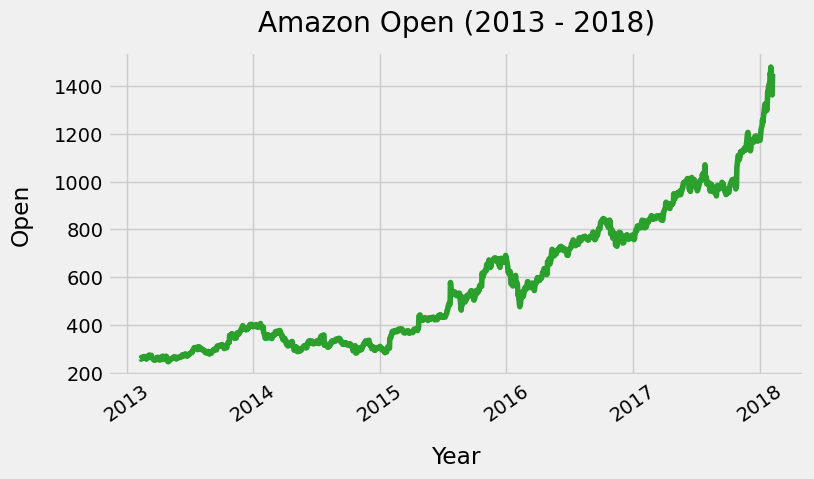

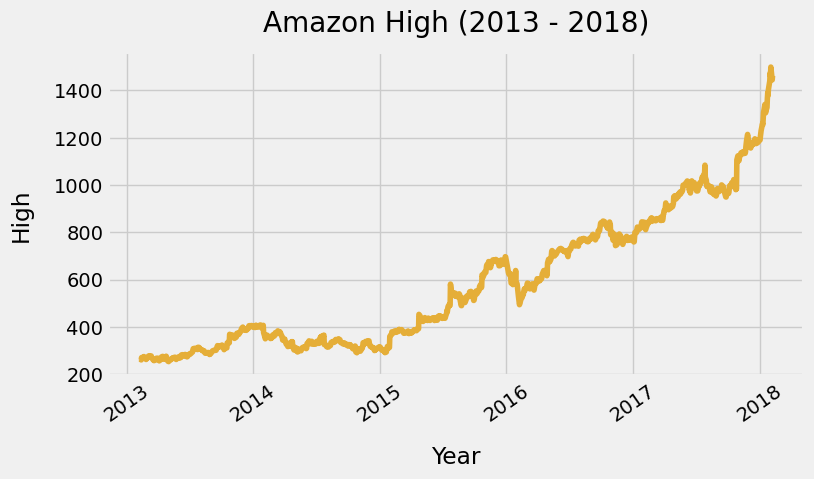

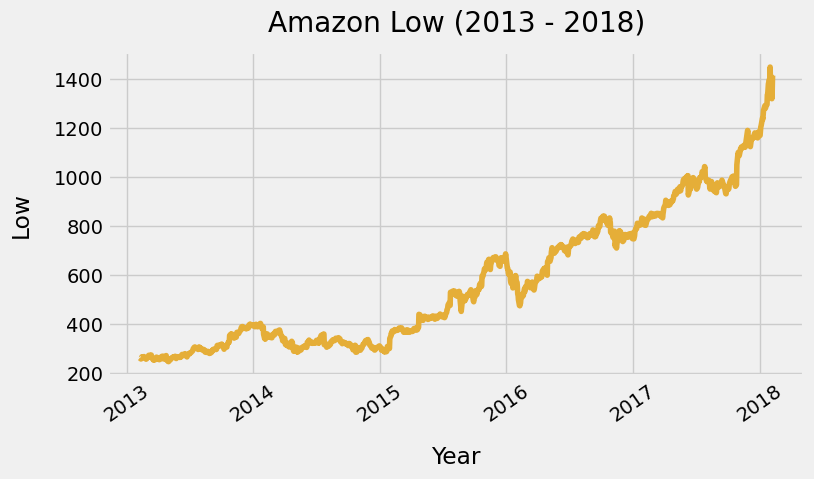

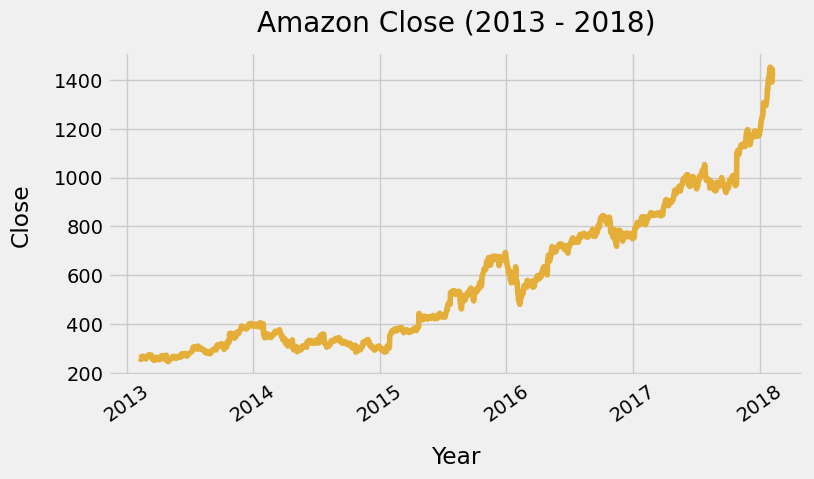

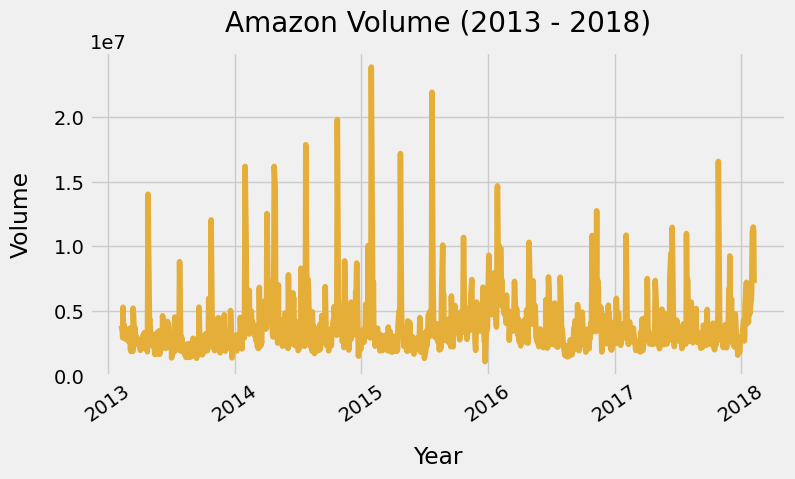

In [12]:
# Call the function
for col in df.columns:
    plot_column_lineplot(df, col)

In [13]:
# Function to plot a KDE plot for a column
def plot_column_kde(df, var):
    """
    Plot a KDE plot for a column in the DataFrame.
    """
    color_palette = sns.color_palette()
    plt.style.use('fivethirtyeight')
    
    plt.figure(figsize=(8, 4))
    plt.grid(True)
    plt.xlabel(f'{var.capitalize()}', labelpad=15)
    plt.ylabel('Density', labelpad=15)
    sns.kdeplot(df[var], color=color_palette[1])
    plt.title(f'Amazon {var.capitalize()} (2013 - 2018)', pad=15)
    plt.xticks(rotation=35)
    plt.show()

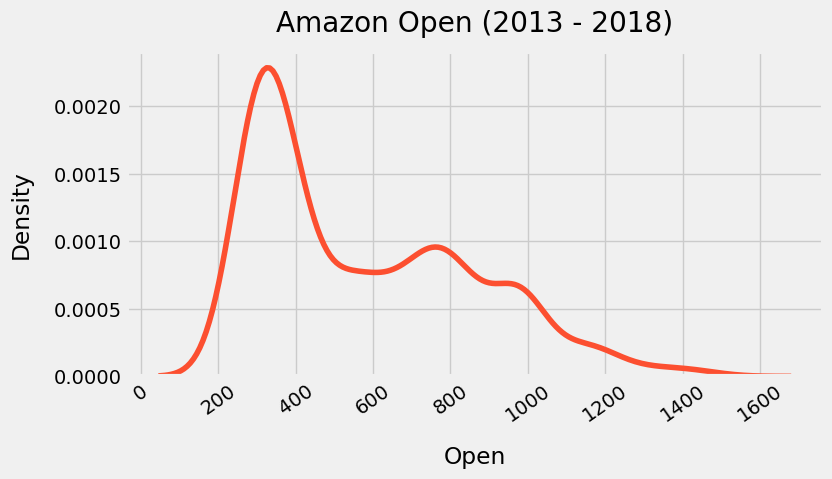

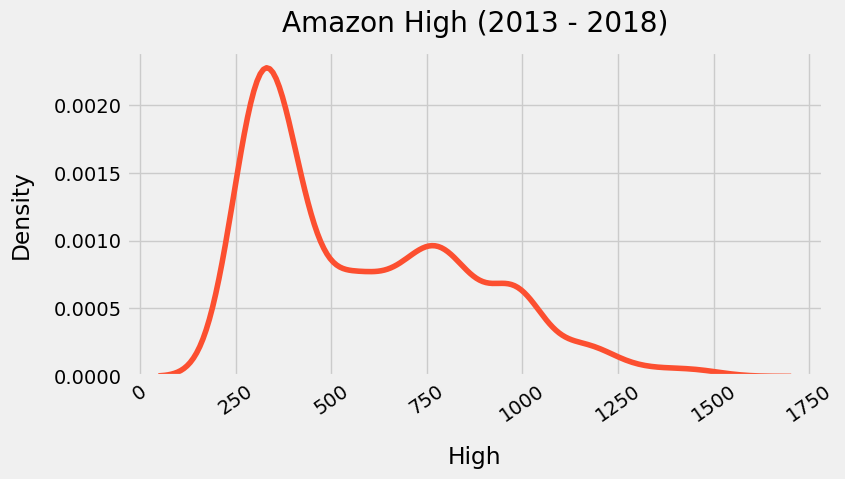

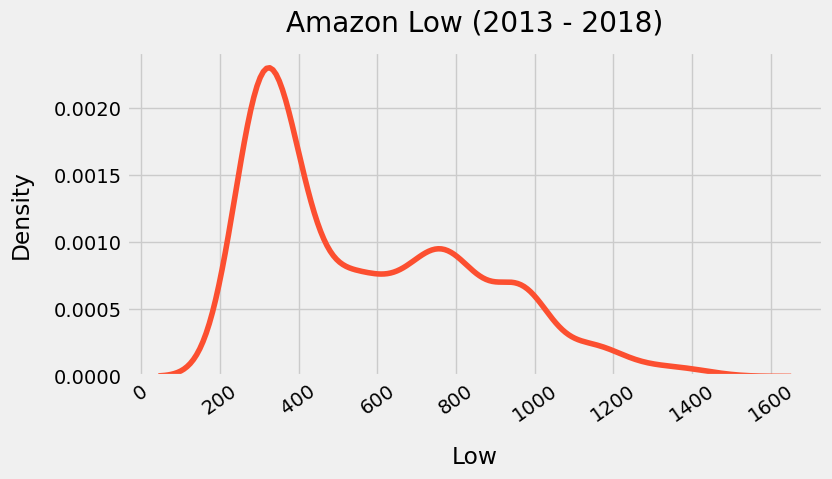

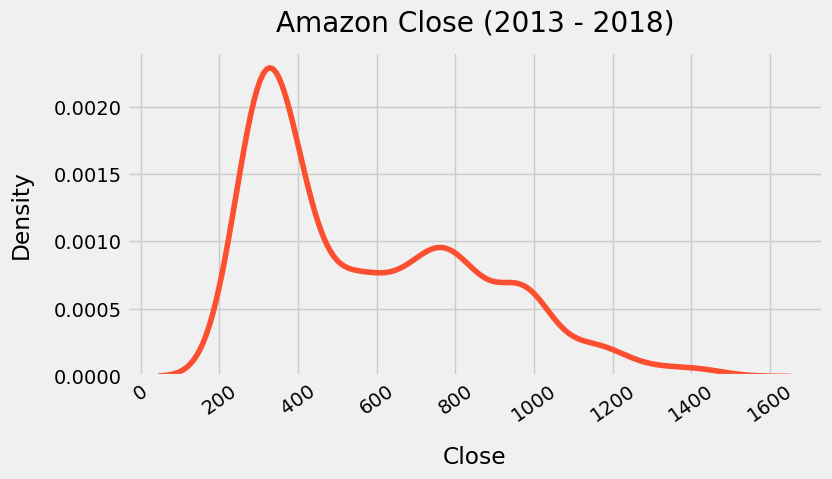

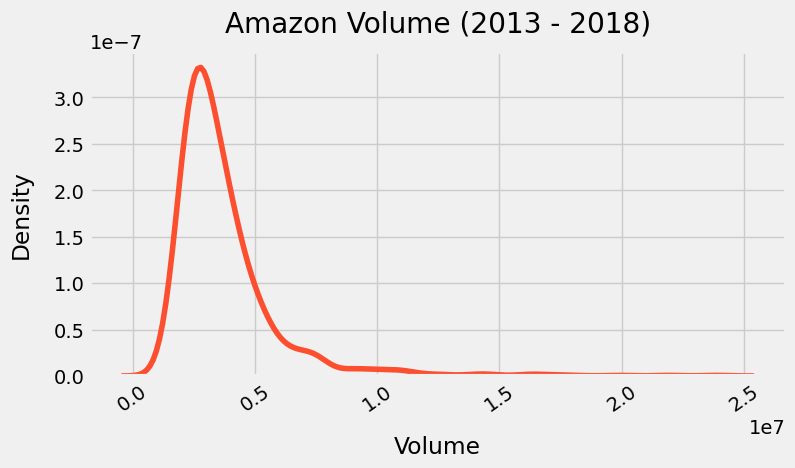

In [14]:
# Call the function
for col in df.columns:
    plot_column_kde(df, col)

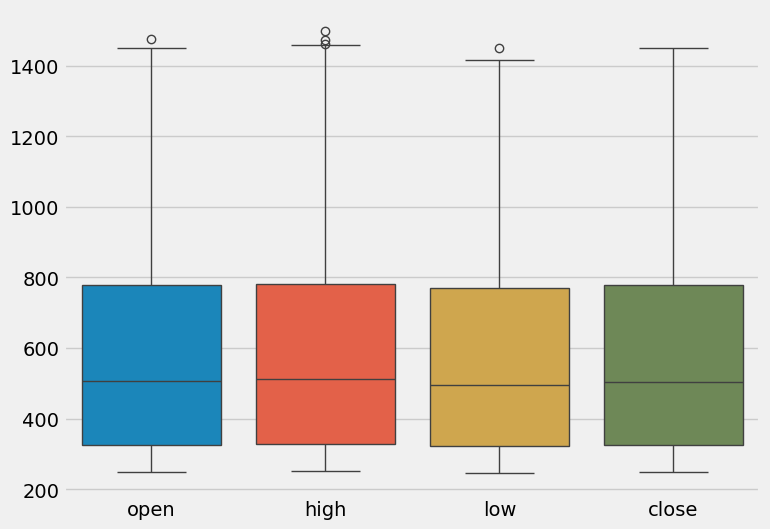

In [15]:
# Boxplots for the columns (except volume due to scale)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df.copy().drop(columns=['volume']))
plt.show()

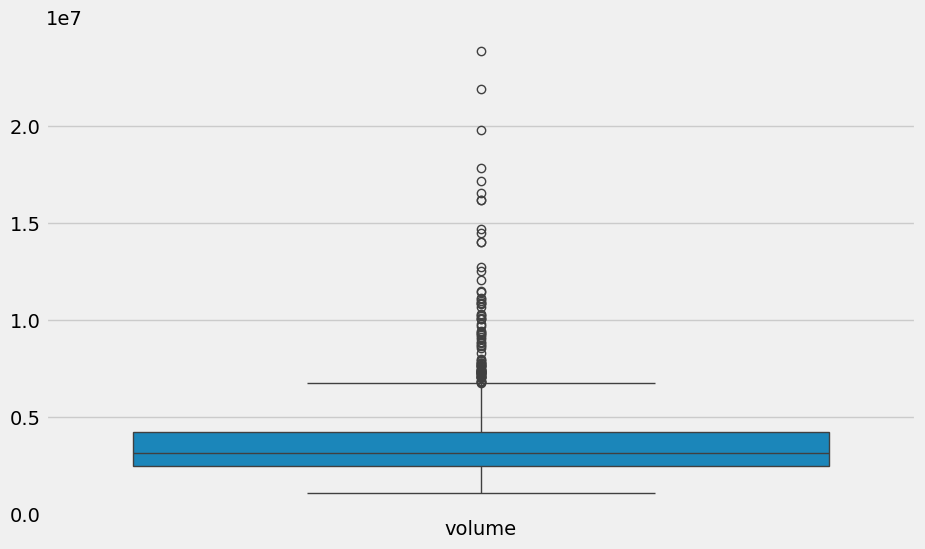

In [16]:
# Boxplot for the volume column
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['volume']])
plt.show()

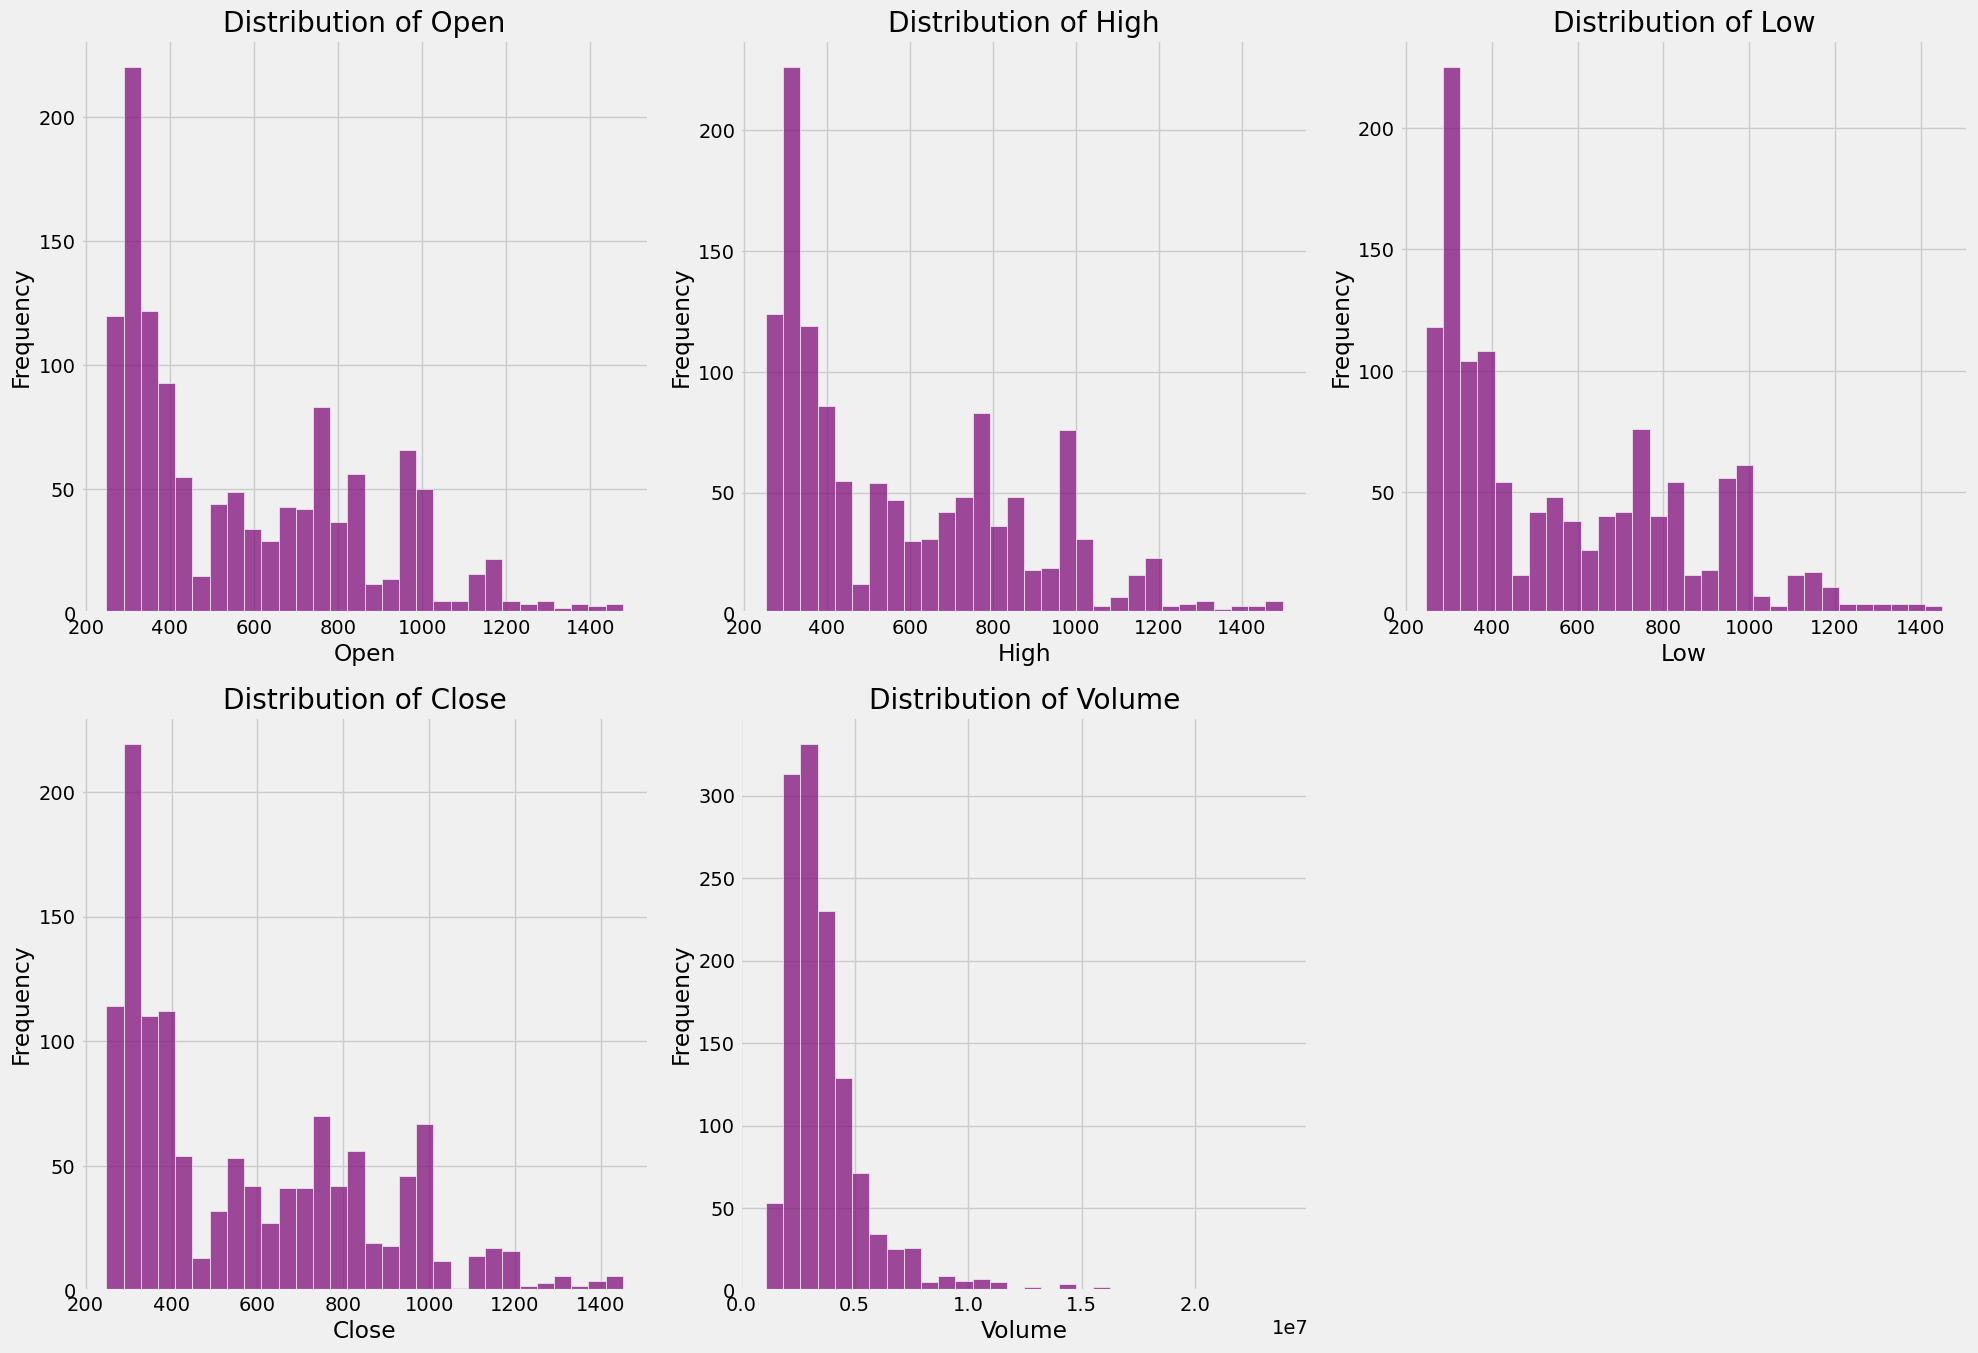

In [17]:
# Histograms for the columns
plt.figure(figsize=(20, 20))
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

for i, var in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=var, bins=30, color=color_palette[5])
    plt.title(f'Distribution of {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

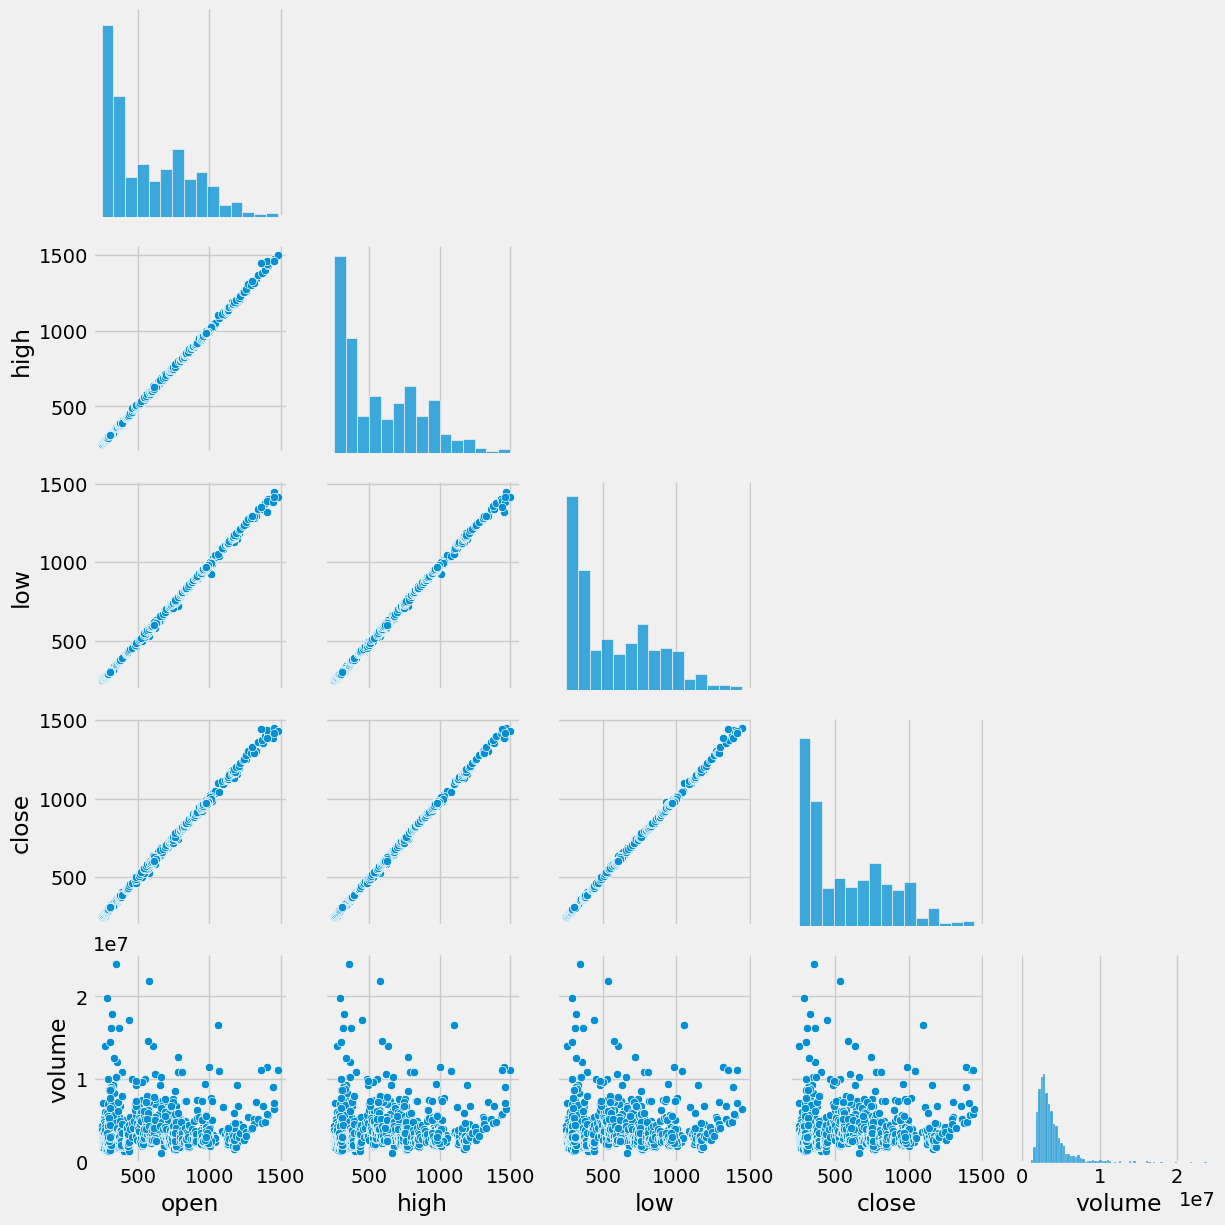

In [18]:
# Scatterplot matrix
scatterplots = sns.pairplot(df, vars=df.columns, corner=True)
scatterplots;

## Boxplots by Time Period

In [19]:
# Use the index for feature creation
def derive_index_features(df):
    """
    Derive time series features based on time series index.
    """
    df_periods = df.copy()
    
    df_periods['dayofweek'] = df.index.dayofweek
    df_periods['quarter'] = df.index.quarter
    df_periods['month'] = df.index.month
    df_periods['year']= df.index.year
    df_periods['dayofyear'] = df.index.dayofyear
    return df_periods

In [20]:
# Call the function
df_periods = derive_index_features(df)

In [21]:
# Function to create boxplots
def create_boxplots(time_period):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=df_periods, x=time_period, y='close', palette='cool')
    ax.set_title(f'Close by {time_period.capitalize()}')
    plt.tight_layout()
    plt.show()

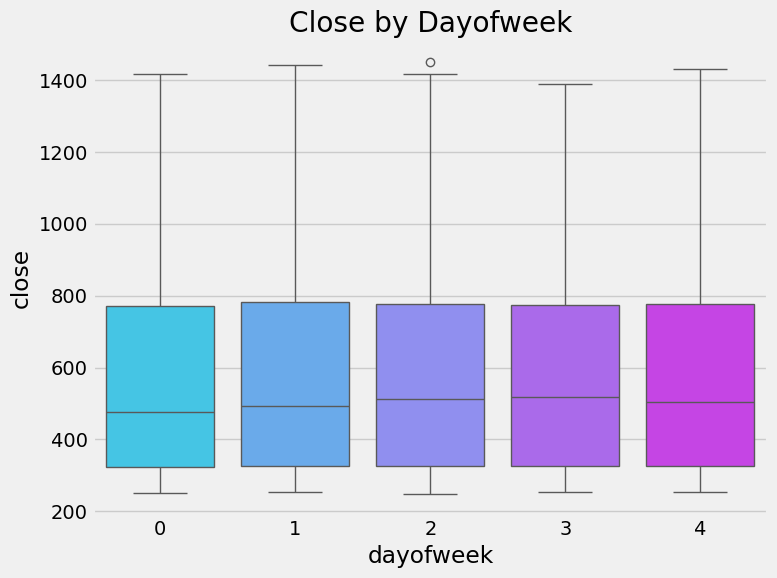

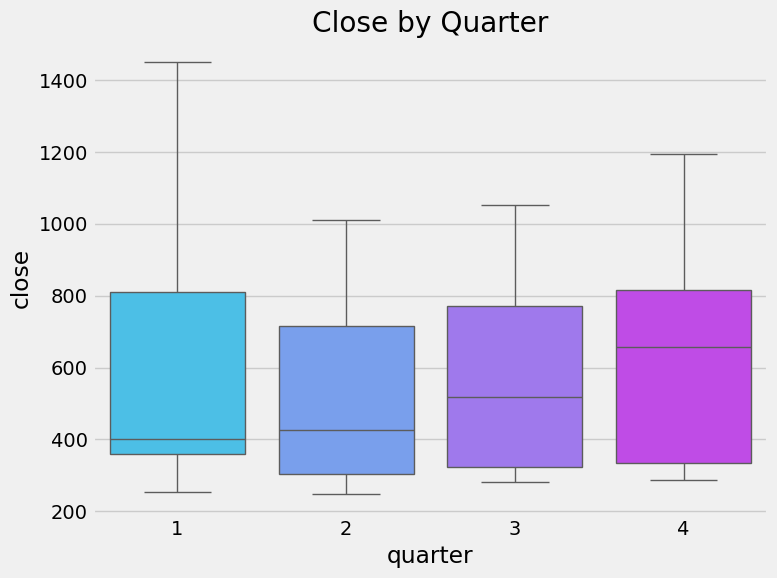

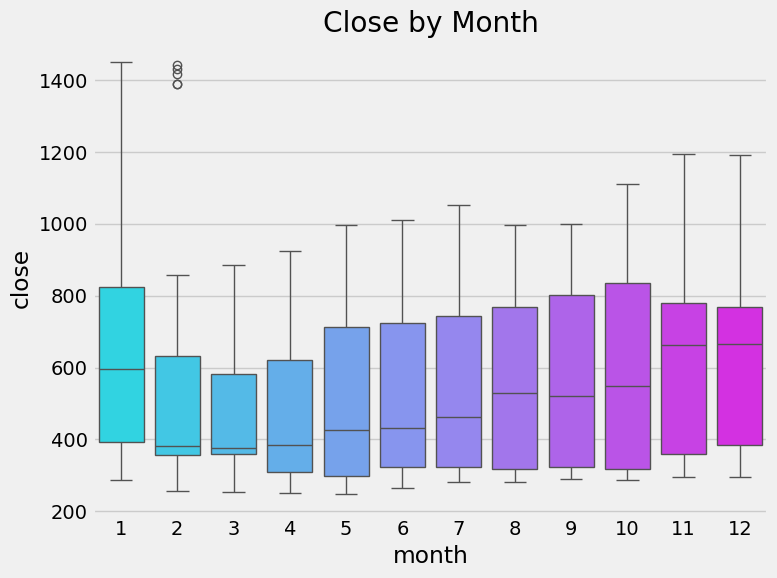

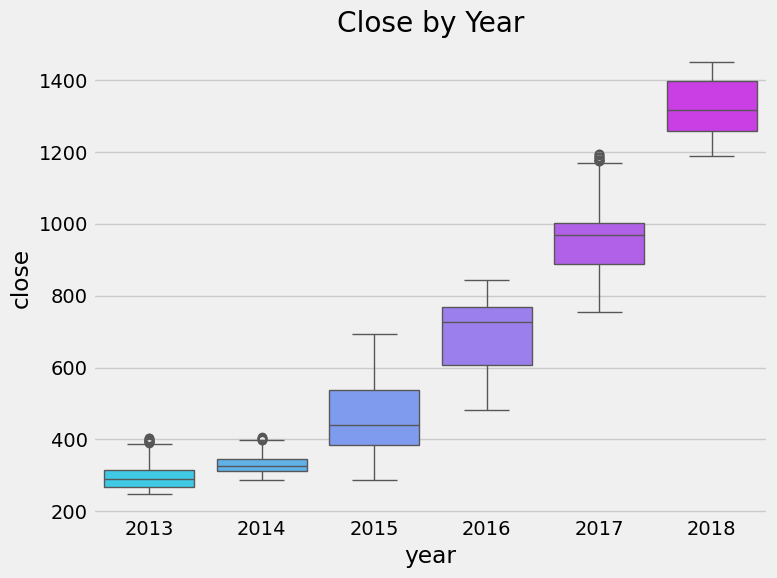

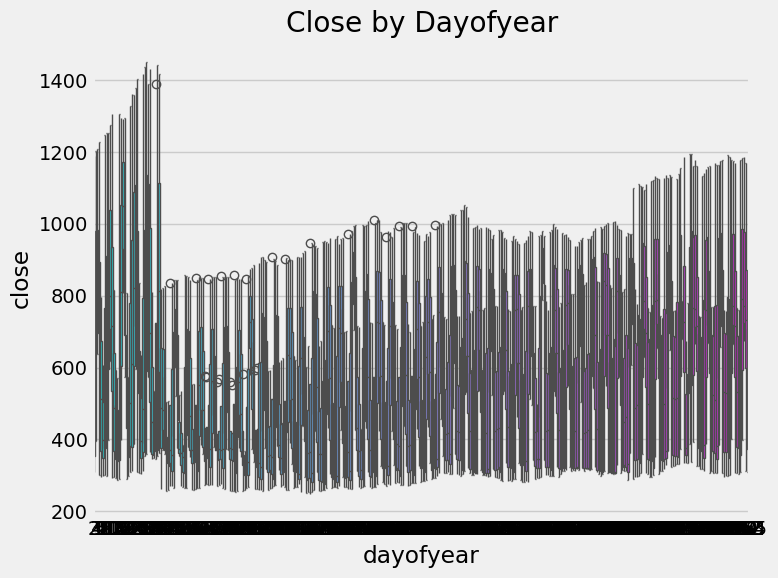

In [22]:
# Create boxplot for each time period except hour
time_periods = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']

for period in time_periods:
    create_boxplots(period)

## Statistics by Time Period

In [23]:
def descriptive_stats_by_time_periods(df, time_periods, target_column='close'):
    """
    Display descriptive statistics for the 'close' column grouped by each time period.
    """
    if target_column not in df.columns:
        print(f"Column '{target_column}' not found in DataFrame.")
        return

    for period in time_periods:
        if period in df.columns:
            print(f"Descriptive Statistics for '{target_column}' by {period.capitalize()}:")
            display(df.groupby(period)[target_column].describe().round(2))
            print("\n" + "-"*50 + "\n")
        else:
            print(f"Column '{period}' not found in DataFrame.")

In [24]:
# Call the function
time_periods = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
descriptive_stats_by_time_periods(df_periods, time_periods)

Descriptive Statistics for 'close' by Dayofweek:


,count,mean,std,min,25%,50%,75%,max
dayofweek,,,,,,,,
0,236.00,570.36,279.54,249.74,324.35,475.74,772.39,1417.68
1,260.00,576.71,284.53,253.81,325.45,492.04,781.50,1442.84
2,259.00,580.29,285.99,248.23,326.65,511.89,776.12,1450.89
3,252.00,577.86,279.93,252.55,326.73,517.08,773.54,1390.00
4,252.00,578.67,284.25,254.81,325.84,504.60,776.87,1429.95



--------------------------------------------------

Descriptive Statistics for 'close' by Quarter:


,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
1,305.00,570.37,304.36,253.39,360.13,401.92,809.72,1450.89
2,317.00,525.93,258.37,248.23,304.91,426.88,715.24,1011.34
3,319.00,575.56,262.54,280.93,323.42,518.01,771.39,1052.80
4,318.00,635.24,293.48,287.06,335.19,656.78,816.48,1195.83



--------------------------------------------------

Descriptive Statistics for 'close' by Month:


,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,101.00,687.19,366.71,286.95,393.63,596.53,823.48,1450.89
2,96.00,532.59,285.31,257.21,356.55,381.00,633.02,1442.84
3,108.00,494.70,212.80,253.39,360.41,375.12,580.90,886.54
4,104.00,489.14,231.33,249.74,309.83,383.50,622.04,924.99
5,106.00,532.88,268.54,248.23,296.91,426.72,711.84,996.70
6,107.00,554.82,270.85,265.70,324.67,432.97,724.64,1011.34
7,106.00,562.14,266.27,282.10,323.86,463.38,744.75,1052.80
8,110.00,582.70,263.72,280.93,317.18,528.46,768.89,995.89
9,103.00,581.74,259.42,288.80,323.94,522.24,801.93,999.60



--------------------------------------------------

Descriptive Statistics for 'close' by Year:


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,226.00,301.56,42.94,248.23,267.32,289.26,315.70,404.39
2014,252.00,332.55,27.67,287.06,311.94,326.42,346.92,407.05
2015,252.00,478.14,110.75,286.95,383.27,439.74,538.52,693.97
2016,252.00,699.52,92.36,482.07,606.93,727.88,767.88,844.36
2017,251.00,968.15,106.58,753.67,889.02,967.99,1002.97,1195.83
2018,26.00,1329.18,81.87,1189.01,1259.92,1316.26,1399.04,1450.89



--------------------------------------------------

Descriptive Statistics for 'close' by Dayofyear:


,count,mean,std,min,25%,50%,75%,max
dayofyear,,,,,,,,
2,3.00,631.83,484.60,308.52,353.24,397.97,793.49,1189.01
3,3.00,784.77,404.78,396.44,575.05,753.67,978.94,1204.20
4,3.00,867.92,301.94,636.99,697.08,757.18,983.38,1209.59
5,4.00,736.39,384.62,302.19,550.89,707.12,892.62,1229.14
6,4.00,529.39,227.28,295.29,369.04,513.14,673.48,795.99
7,3.00,434.80,158.00,298.42,348.22,398.03,502.98,607.94
8,4.00,639.07,424.79,300.46,376.56,504.48,767.00,1246.87
9,4.00,686.89,434.37,296.93,374.99,598.96,910.86,1252.70
10,3.00,815.96,428.69,397.66,596.78,795.90,1025.12,1254.33



--------------------------------------------------



## Stationarity Test

In [25]:
# Augmented Dickey-Fuller test for each column
for col in df.columns:
    result = adfuller(df[col])
    print(f'ADF Statistic for {col.capitalize()}: {result[0]}')
    print(f'p-value for {col.capitalize()}: {result[1]}')
    for key, value in result[4].items():
        print(f'   Critical Values for {col.capitalize()} ({key}): {value}')
    print('\n')

ADF Statistic for Open: 2.9528687629903296
p-value for Open: 1.0
   Critical Values for Open (1%): -3.4355754676859886
   Critical Values for Open (5%): -2.8638475772391665
   Critical Values for Open (10%): -2.5679985805677017


ADF Statistic for High: 2.705343270893862
p-value for High: 0.9990872825339394
   Critical Values for High (1%): -3.4355796466416777
   Critical Values for High (5%): -2.863849421064024
   Critical Values for High (10%): -2.5679995625056926


ADF Statistic for Low: 2.539989151856321
p-value for Low: 0.9990616213522052
   Critical Values for Low (1%): -3.435571295403709
   Critical Values for Low (5%): -2.863845736356174
   Critical Values for Low (10%): -2.567997600196822


ADF Statistic for Close: 2.483784607303794
p-value for Close: 0.999044434464538
   Critical Values for Close (1%): -3.435571295403709
   Critical Values for Close (5%): -2.863845736356174
   Critical Values for Close (10%): -2.567997600196822


ADF Statistic for Volume: -7.631877744712762
p

In [26]:
# ADF test results for each column
adf_results = {
    'Open': (2.9529, 1.0),
    'High': (2.7053, 0.9991),
    'Low': (2.5400, 0.9991),
    'Close': (2.4838, 0.9990),
    'Volume': (-7.6319, 1.9988e-11)
}

# Prepare data for plotting
columns = list(adf_results.keys())
adf_statistics = [adf_results[col][0] for col in columns]
p_values = [adf_results[col][1] for col in columns]

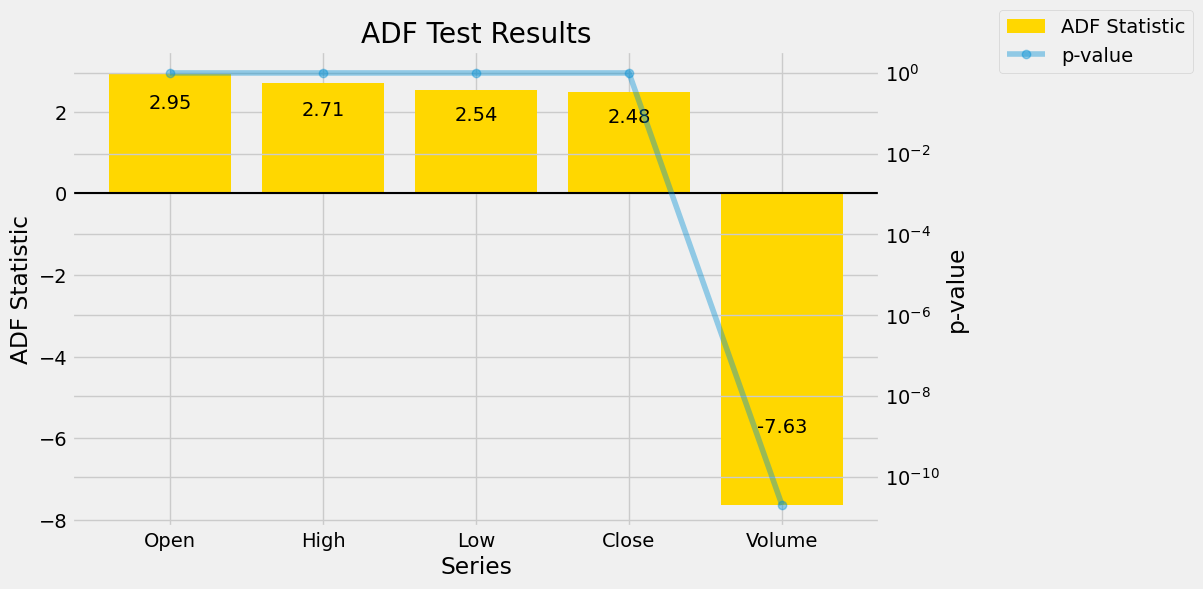

In [27]:
# Plot the ADF results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for ADF statistics
bars = ax1.bar(columns, adf_statistics, color='gold', label='ADF Statistic')
for bar in bars:
    yval = bar.get_height()
    label_position = yval * 0.75
    ax1.text(bar.get_x() + bar.get_width()/2, label_position, round(yval, 2), ha='center', va='center')

ax1.set_xlabel('Series')
ax1.set_ylabel('ADF Statistic')
ax1.tick_params(axis='y')
ax1.axhline(0, color='black', linewidth=1.5)

# Add the p-values as a line plot
ax2 = ax1.twinx()
ax2.plot(columns, p_values, marker='o', alpha=0.4, label='p-value')
ax2.set_ylabel('p-value')
ax2.tick_params(axis='y')
ax2.set_yscale('log')

plt.title('ADF Test Results')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the legend placement
plt.show()

## Seasonality Test

In [28]:
# Yearly decomposition
decomposition_yearly = seasonal_decompose(df['close'], model='additive', period=252)

# Quarterly decomposition
decomposition_quarterly = seasonal_decompose(df['close'], model='additive', period=63)

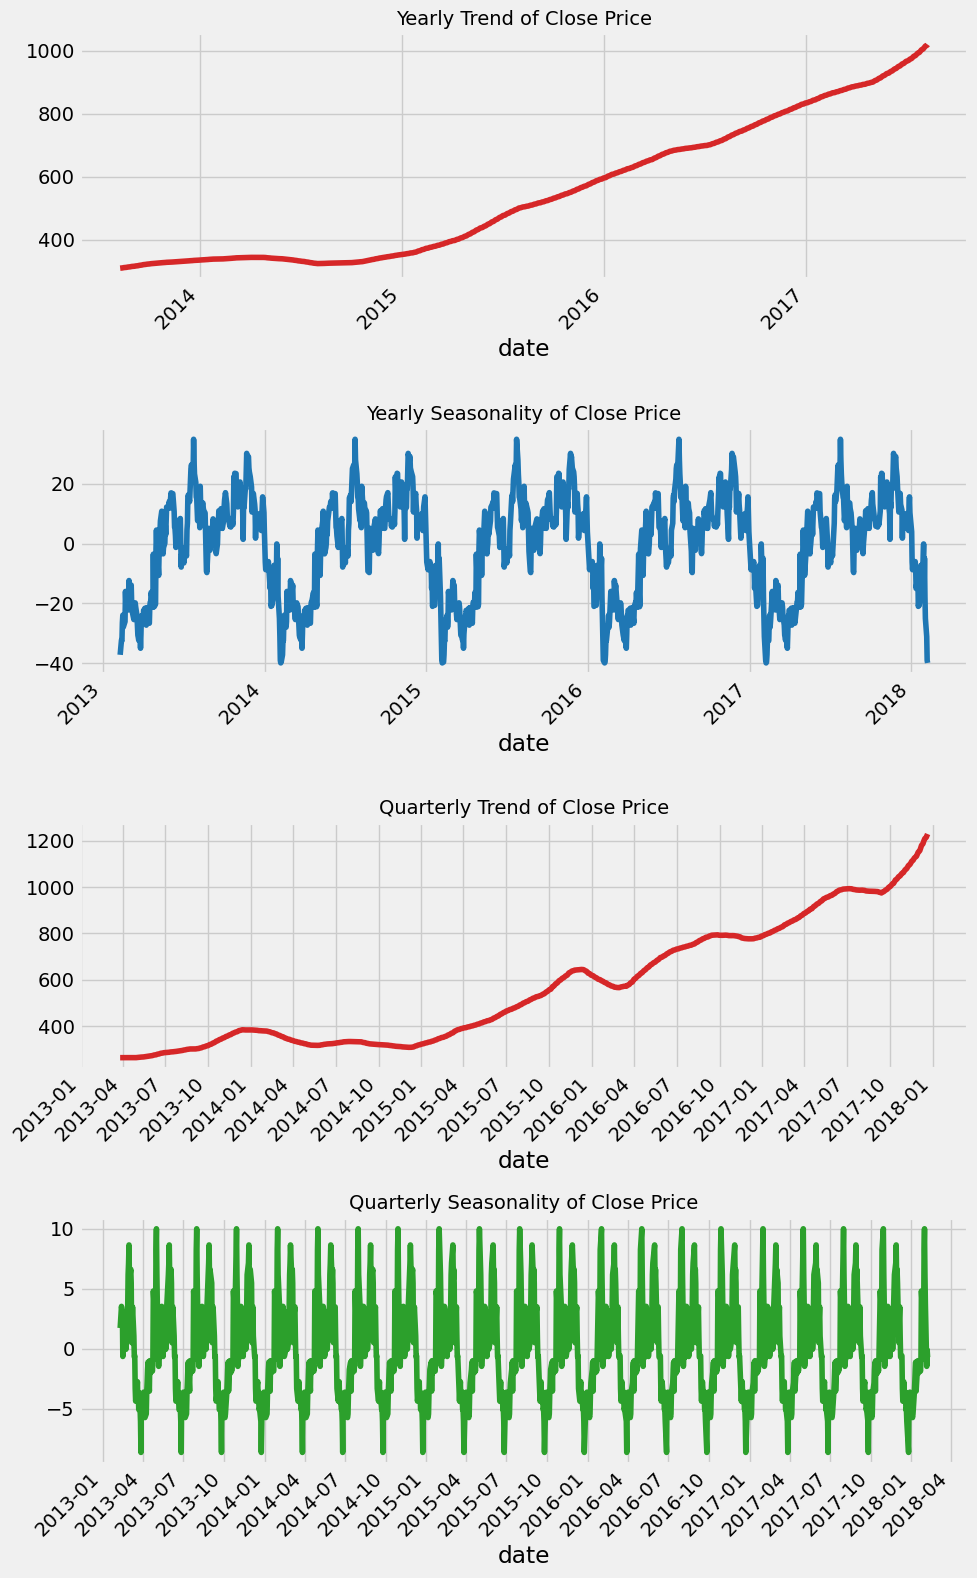

In [29]:
# Plot the seasonal and trend decompositions for 'close' price
fig, axs = plt.subplots(4, 1, figsize=(10, 16))

# Yearly Decomposition - Trend
axs[0].set_title('Yearly Trend of Close Price', fontsize=14)
decomposition_yearly.trend.plot(ax=axs[0], color='tab:red')
axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].tick_params(axis='x', rotation=45)

# Yearly Decomposition - Seasonality
axs[1].set_title('Yearly Seasonality of Close Price', fontsize=14)
decomposition_yearly.seasonal.plot(ax=axs[1], color='tab:blue')
axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].tick_params(axis='x', rotation=45)

# Quarterly Decomposition - Trend
axs[2].set_title('Quarterly Trend of Close Price', fontsize=14)
decomposition_quarterly.trend.plot(ax=axs[2], color='tab:red')
axs[2].xaxis.set_major_locator(MonthLocator(bymonth=(1, 4, 7, 10)))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[2].tick_params(axis='x', rotation=45)

# Quarterly Decomposition - Seasonality
axs[3].set_title('Quarterly Seasonality of Close Price', fontsize=14)
decomposition_quarterly.seasonal.plot(ax=axs[3], color='tab:green')
axs[3].xaxis.set_major_locator(MonthLocator(bymonth=(1, 4, 7, 10)))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Autocorrelation Test

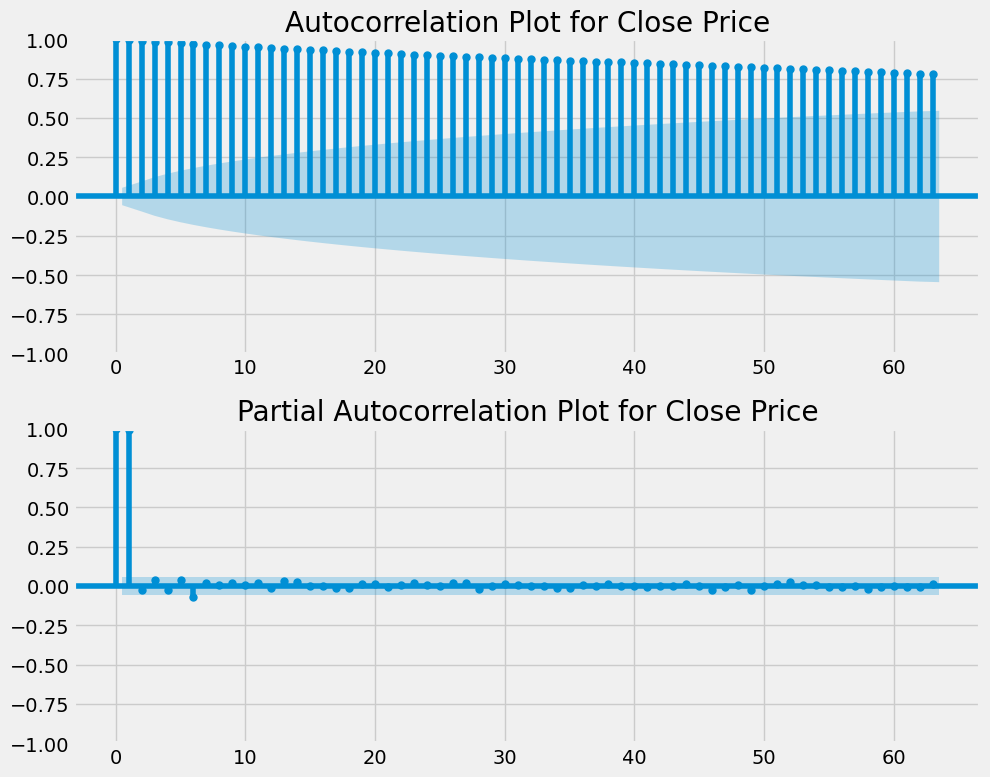

In [30]:
# ACF and PACF plots for 'close' price
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF
plot_acf(df['close'], ax=axes[0], lags=63, alpha=0.05)
axes[0].set_title('Autocorrelation Plot for Close Price')

# Plot the PACF
plot_pacf(df['close'], ax=axes[1], lags=63, alpha=0.05)
axes[1].set_title('Partial Autocorrelation Plot for Close Price')

plt.tight_layout()
plt.show()

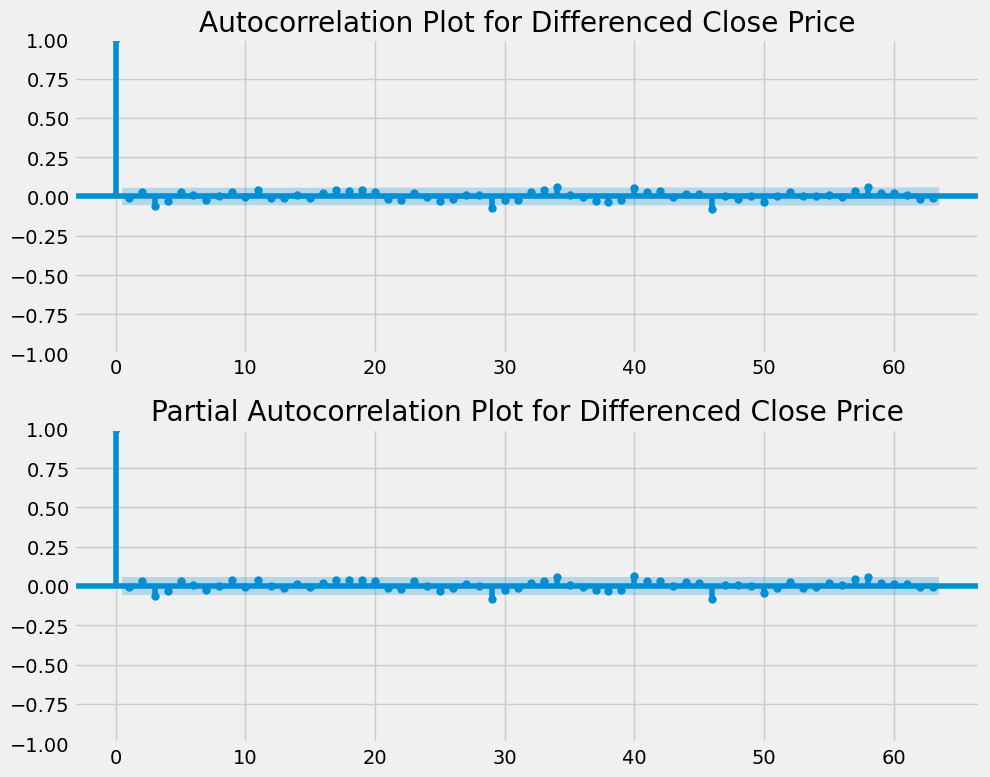

In [31]:
# Differencing the 'close' price
df_diff = df['close'].diff().dropna()

# ACF and PACF plots for the differenced data
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF for the differenced data
plot_acf(df_diff, ax=axes[0], lags=63, alpha=0.05)
axes[0].set_title('Autocorrelation Plot for Differenced Close Price')

# Plot the PACF for the differenced data
plot_pacf(df_diff, ax=axes[1], lags=63, alpha=0.05)
axes[1].set_title('Partial Autocorrelation Plot for Differenced Close Price')

plt.tight_layout()
plt.show()

## Anomaly Detection

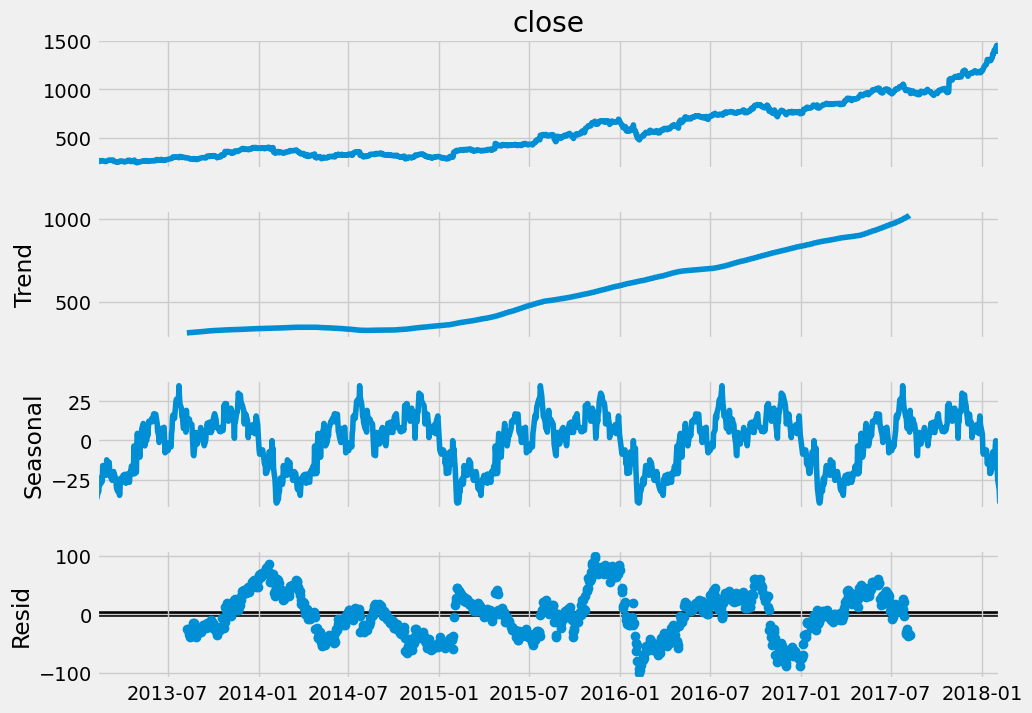

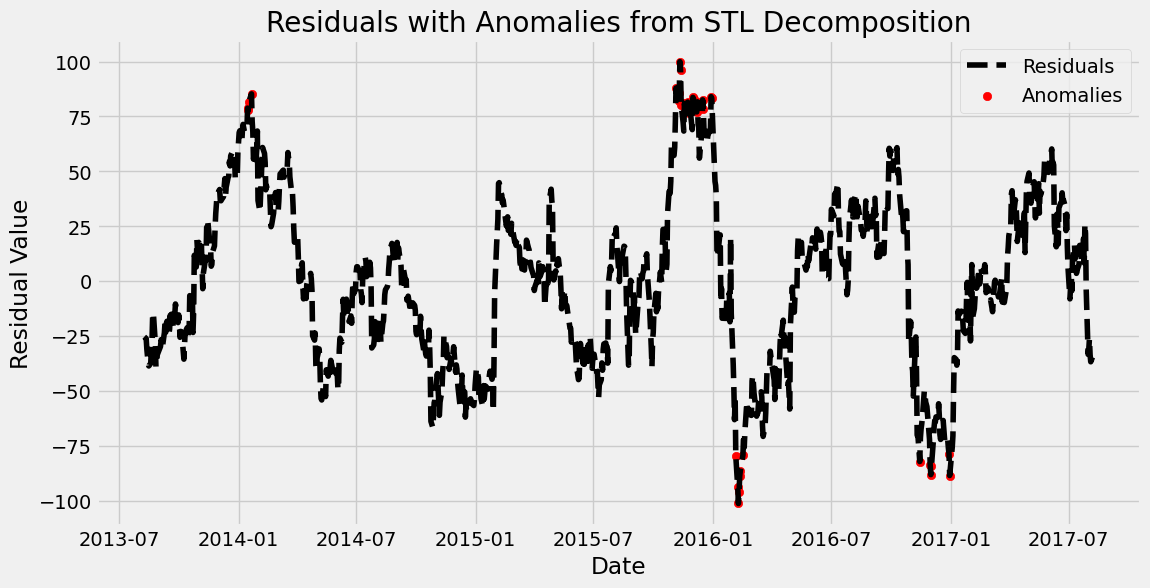

In [32]:
# Perform STL decomposition
stl_decomposition = seasonal_decompose(df['close'], model='additive', period=252)

# Plot the decomposition
decomposition_fig = stl_decomposition.plot()
decomposition_fig.set_size_inches(12, 8)
plt.show()

# Detect anomalies in residuals
residuals = stl_decomposition.resid.dropna()
residuals_mean = residuals.mean()
residuals_std = residuals.std()

# Identify points where the residual deviates significantly from the mean
anomalies = residuals[np.abs(residuals - residuals_mean) > 2 * residuals_std]

# Plot residuals with anomalies
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals.values, color='black', linestyle='--', label='Residuals')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Residuals with Anomalies from STL Decomposition')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

## Lag Plots

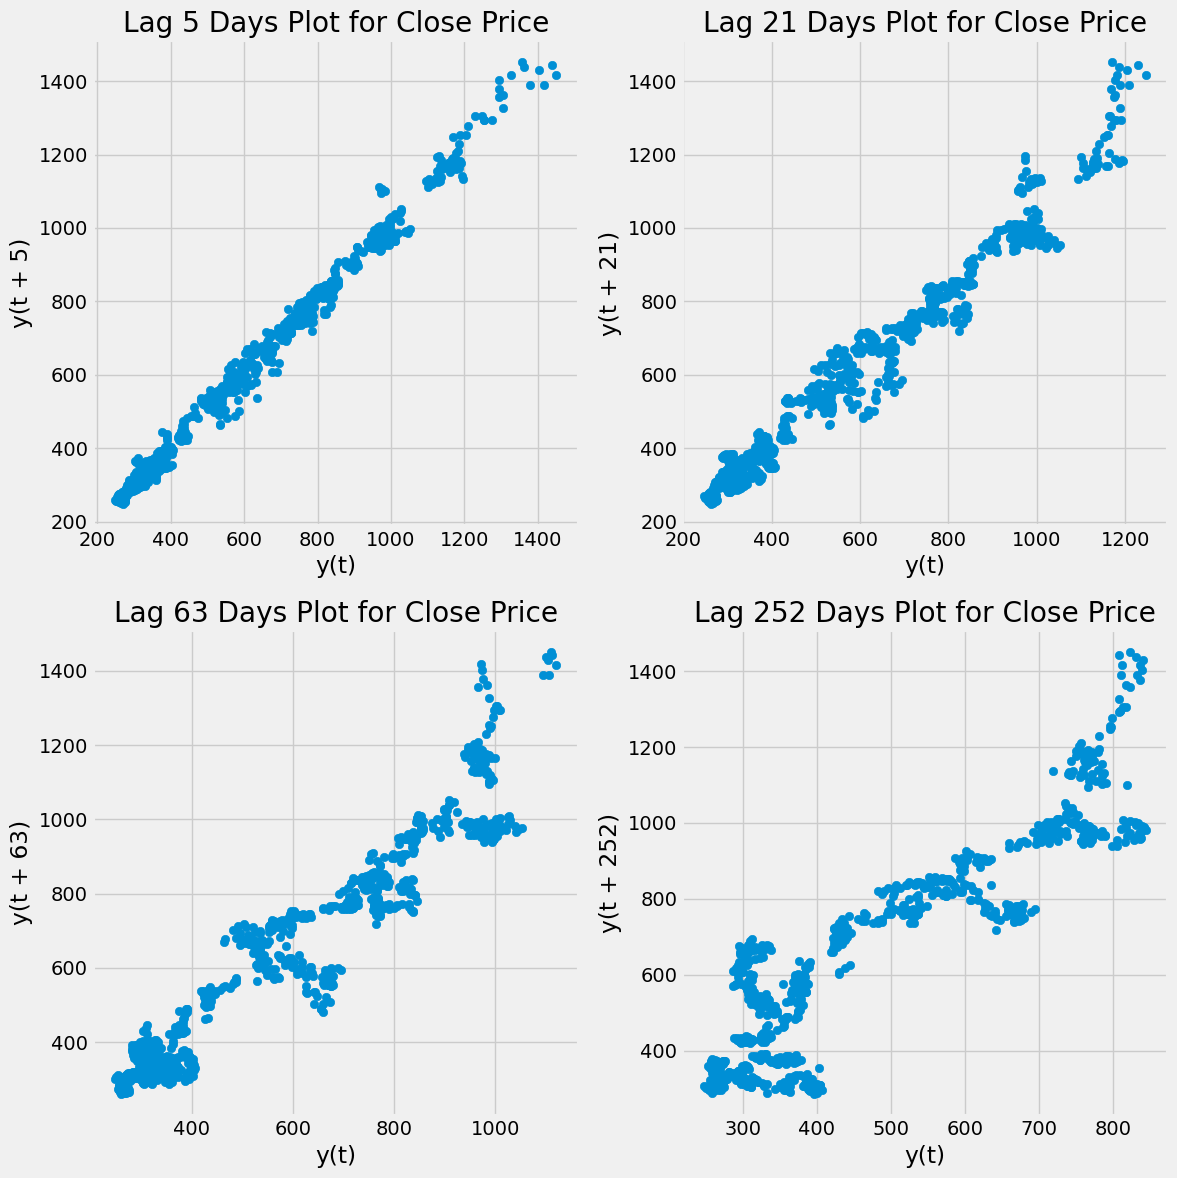

In [33]:
# Lag plots with specified time periods
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
lags = [5, 21, 63, 252]  # Lag values for a trading week, month, quarter, and year

for i, lag in enumerate(lags):
    ax = axes[i//2, i % 2]
    lag_plot(df['close'], lag=lag, ax=ax)
    ax.set_title(f'Lag {lag} Days Plot for Close Price')

plt.tight_layout()
plt.show()

## Statistical Tests

In [34]:
# Mann-Kendall trend test
mk_result = mk.original_test(df['close'])
mk_result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=44.54056248759654, Tau=0.8380222019898701, s=663639.0, var_s=221999040.33333334, slope=0.7217110655737704, intercept=49.86373975409839)

In [35]:
# Granger Causality tests
columns_to_test = ['open', 'high', 'low', 'volume']
granger_results = {}

for col in columns_to_test:
    # Combine the 'close' column with the column to test
    data_to_test = df[['close', col]]
    
    # Perform Granger Causality test
    granger_results[col] = grangercausalitytests(data_to_test, maxlag=40, verbose=False)

# Extract p-values from the results
granger_p_values = pd.DataFrame({col: [granger_results[col][lag+1][0]['ssr_chi2test'][1] for lag in range(40)] for col in columns_to_test})
granger_p_values

,open,high,low,volume
0,0.21,0.07,0.87,0.44
1,0.47,0.11,0.18,0.23
2,0.08,0.16,0.09,0.37
3,0.18,0.07,0.07,0.30
4,0.46,0.20,0.01,0.33
5,0.38,0.08,0.01,0.40
6,0.12,0.02,0.01,0.45
7,0.26,0.04,0.02,0.39
8,0.25,0.03,0.02,0.12
9,0.40,0.05,0.04,0.16


In [36]:
# Count p-values less than 0.05 for each column
p_value_count = (granger_p_values < 0.05).sum()
p_value_count

open       0
high      15
low       29
volume     0
dtype: int64

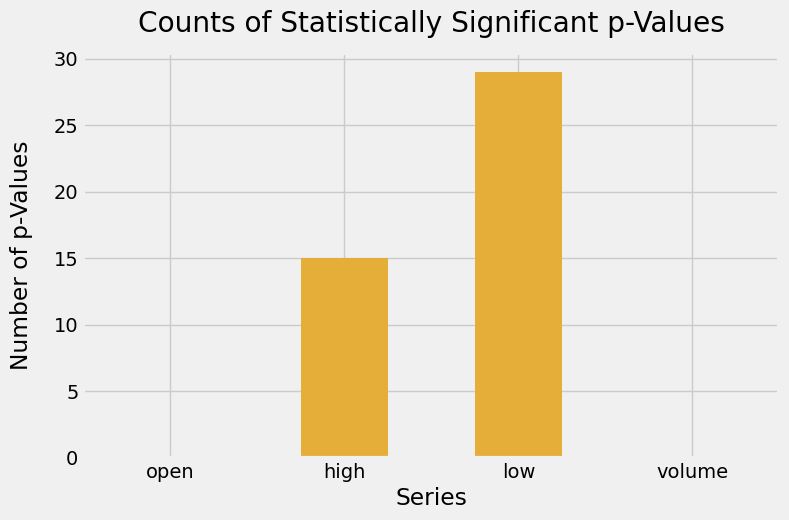

In [37]:
# Plot the counts
plt.figure(figsize=(8, 5))
p_value_count.plot(kind='bar', color=color_palette[2])
plt.xlabel('Series')
plt.ylabel('Number of p-Values', labelpad=15)
plt.title('Counts of Statistically Significant p-Values', pad=15)
plt.xticks(rotation=0)
plt.show()

# Feature Engineering

In [38]:
# Use the index for feature creation
def add_index_features(df):
    """
    Add time series features based on time series index.
    """
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year']= df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [39]:
# Call the function
df = add_index_features(df)

In [40]:
# View the results
df.head()

,open,high,low,close,volume,dayofweek,quarter,month,year,dayofyear
date,,,,,,,,,,
2013-02-08,261.40,265.25,260.56,261.95,3879078,4,1,2,2013,39
2013-02-11,263.20,263.25,256.60,257.21,3403403,0,1,2,2013,42
2013-02-12,259.19,260.16,257.00,258.70,2938660,1,1,2,2013,43
2013-02-13,261.53,269.96,260.30,269.47,5292996,2,1,2,2013,44
2013-02-14,267.37,270.65,265.40,269.24,3462780,3,1,2,2013,45


In [41]:
# Add differenced, lagged, and rolling features
def generate_features(df, columns_to_generate=None):
    """
    Generate differenced, lagged, and rolling window features for specified columns in the DataFrame.
    """
    periods = {'week': 5, 'month': 21, 'quarter': 63, 'year': 252}

    if columns_to_generate is None:
        columns_to_generate = df.columns

    for col in columns_to_generate:
        # Check if column exists in DataFrame
        if col not in df.columns:
            continue
        
        # First-order differencing
        df[f'{col}_diff'] = df[col].diff()

        # Logarithmic differencing
        df[f'{col}_log'] = np.log(df[col].clip(lower=0.01))
        df[f'{col}_log_diff'] = df[f'{col}_log'].diff()

        # Seasonal differencing
        df[f'{col}_quarter_diff'] = df[col].diff(periods=63)
        df[f'{col}_year_diff'] = df[col].diff(periods=252)
        
        # Generate lagged features for each column
        for period, lag in periods.items():
            df[f'{col}_lag_{period}'] = df[col].shift(lag)

        # Generate rolling window features for each column
        for period, window in periods.items():
            df[f'{col}_rolling_mean_{period}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_median_{period}'] = df[col].rolling(window=window).median()
            df[f'{col}_rolling_var_{period}'] = df[col].rolling(window=window).var()
            df[f'{col}_rolling_std_{period}'] = df[col].rolling(window=window).std()

            # Expanding window features
            df[f'{col}_expanding_mean_{period}'] = df[col].expanding(min_periods=window).mean()

            # Exponential weighted moving window features
            df[f'{col}_ewm_mean_{period}'] = df[col].ewm(span=window).mean()

    return df

In [42]:
# Call the function
df = generate_features(df, ['close', 'low'])

In [43]:
# View the results
df.head()

,open,high,low,close,volume,dayofweek,quarter,month,year,dayofyear,close_diff,close_log,close_log_diff,close_quarter_diff,close_year_diff,close_lag_week,close_lag_month,close_lag_quarter,close_lag_year,close_rolling_mean_week,close_rolling_median_week,close_rolling_var_week,close_rolling_std_week,close_expanding_mean_week,close_ewm_mean_week,close_rolling_mean_month,close_rolling_median_month,close_rolling_var_month,close_rolling_std_month,close_expanding_mean_month,close_ewm_mean_month,close_rolling_mean_quarter,close_rolling_median_quarter,close_rolling_var_quarter,close_rolling_std_quarter,close_expanding_mean_quarter,close_ewm_mean_quarter,close_rolling_mean_year,close_rolling_median_year,close_rolling_var_year,close_rolling_std_year,close_expanding_mean_year,close_ewm_mean_year,low_diff,low_log,low_log_diff,low_quarter_diff,low_year_diff,low_lag_week,low_lag_month,low_lag_quarter,low_lag_year,low_rolling_mean_week,low_rolling_median_week,low_rolling_var_week,low_rolling_std_week,low_expanding_mean_week,low_ewm_mean_week,low_rolling_mean_month,low_rolling_median_month,low_rolling_var_month,low_rolling_std_month,low_expanding_mean_month,low_ewm_mean_month,low_rolling_mean_quarter,low_rolling_median_quarter,low_rolling_var_quarter,low_rolling_std_quarter,low_expanding_mean_quarter,low_ewm_mean_quarter,low_rolling_mean_year,low_rolling_median_year,low_rolling_var_year,low_rolling_std_year,low_expanding_mean_year,low_ewm_mean_year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-08,261.40,265.25,260.56,261.95,3879078,4,1,2,2013,39,NaN,5.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.95,NaN,NaN,NaN,NaN,NaN,261.95,NaN,NaN,NaN,NaN,NaN,261.95,NaN,NaN,NaN,NaN,NaN,261.95,NaN,5.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.56,NaN,NaN,NaN,NaN,NaN,260.56,NaN,NaN,NaN,NaN,NaN,260.56,NaN,NaN,NaN,NaN,NaN,260.56
2013-02-11,263.20,263.25,256.60,257.21,3403403,0,1,2,2013,42,-4.74,5.55,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.11,NaN,NaN,NaN,NaN,NaN,259.47,NaN,NaN,NaN,NaN,NaN,259.54,NaN,NaN,NaN,NaN,NaN,259.57,-3.95,5.55,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.18,NaN,NaN,NaN,NaN,NaN,258.48,NaN,NaN,NaN,NaN,NaN,258.55,NaN,NaN,NaN,NaN,NaN,258.57
2013-02-12,259.19,260.16,257.00,258.70,2938660,1,1,2,2013,43,1.49,5.56,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.91,NaN,NaN,NaN,NaN,NaN,259.19,NaN,NaN,NaN,NaN,NaN,259.25,NaN,NaN,NaN,NaN,NaN,259.28,0.40,5.55,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257.62,NaN,NaN,NaN,NaN,NaN,257.94,NaN,NaN,NaN,NaN,NaN,258.01,NaN,NaN,NaN,NaN,NaN,258.04
2013-02-13,261.53,269.96,260.30,269.47,5292996,2,1,2,2013,44,10.77,5.60,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.30,NaN,NaN,NaN,NaN,NaN,262.14,NaN,NaN,NaN,NaN,NaN,261.93,NaN,NaN,NaN,NaN,NaN,261.86,3.30,5.56,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.73,NaN,NaN,NaN,NaN,NaN,258.62,NaN,NaN,NaN,NaN,NaN,258.61,NaN,NaN,NaN,NaN,NaN,258.61
2013-02-14,267.37,270.65,265.40,269.24,3462780,3,1,2,2013,45,-0.23,5.60,-0.00,NaN,NaN,NaN,NaN,NaN,NaN,263.31,261.95,33.36,5.78,263.31,265.58,NaN,NaN,NaN,NaN,NaN,263.84,NaN,NaN,NaN,NaN,NaN,263.49,NaN,NaN,NaN,NaN,NaN,263.36,5.10,5.58,0.02,NaN,NaN,NaN,NaN,NaN,NaN,259.97,260.30,12.53,3.54,259.97,261.29,NaN,NaN,NaN,NaN,NaN,260.24,NaN,NaN,NaN,NaN,NaN,260.06,NaN,NaN,NaN,NaN,NaN,259.99


In [44]:
# Print total number of features
print(f'There are {len(df.columns)} features in the dataset')

There are 76 features in the dataset


# Missing Values

In [45]:
# Print number of rows with missing values
df.isnull().any(axis=1).sum()

252

In [46]:
# Drop missing values due to lags
df.dropna(inplace=True)

In [47]:
# Print number of remaining missing values
df.isnull().sum().sum()

0

In [48]:
# View the new data
df.head()

,open,high,low,close,volume,dayofweek,quarter,month,year,dayofyear,close_diff,close_log,close_log_diff,close_quarter_diff,close_year_diff,close_lag_week,close_lag_month,close_lag_quarter,close_lag_year,close_rolling_mean_week,close_rolling_median_week,close_rolling_var_week,close_rolling_std_week,close_expanding_mean_week,close_ewm_mean_week,close_rolling_mean_month,close_rolling_median_month,close_rolling_var_month,close_rolling_std_month,close_expanding_mean_month,close_ewm_mean_month,close_rolling_mean_quarter,close_rolling_median_quarter,close_rolling_var_quarter,close_rolling_std_quarter,close_expanding_mean_quarter,close_ewm_mean_quarter,close_rolling_mean_year,close_rolling_median_year,close_rolling_var_year,close_rolling_std_year,close_expanding_mean_year,close_ewm_mean_year,low_diff,low_log,low_log_diff,low_quarter_diff,low_year_diff,low_lag_week,low_lag_month,low_lag_quarter,low_lag_year,low_rolling_mean_week,low_rolling_median_week,low_rolling_var_week,low_rolling_std_week,low_expanding_mean_week,low_ewm_mean_week,low_rolling_mean_month,low_rolling_median_month,low_rolling_var_month,low_rolling_std_month,low_expanding_mean_month,low_ewm_mean_month,low_rolling_mean_quarter,low_rolling_median_quarter,low_rolling_var_quarter,low_rolling_std_quarter,low_expanding_mean_quarter,low_ewm_mean_quarter,low_rolling_mean_year,low_rolling_median_year,low_rolling_var_year,low_rolling_std_year,low_expanding_mean_year,low_ewm_mean_year
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-10,361.61,365.00,359.35,360.87,3451093,0,1,2,2014,41,-0.21,5.89,-0.00,17.31,98.92,346.15,401.01,343.56,261.95,354.19,354.59,47.77,6.91,310.53,358.98,381.92,390.98,462.63,21.51,310.53,375.25,383.35,387.60,305.73,17.49,310.53,374.57,310.72,297.09,2362.39,48.60,310.53,336.13,6.86,5.88,0.02,17.47,98.80,340.10,398.44,341.88,260.56,348.20,347.40,67.61,8.22,306.98,353.65,376.91,387.27,473.80,21.77,306.98,370.10,378.95,383.80,322.06,17.95,306.98,370.09,307.16,295.26,2311.57,48.08,306.98,332.28
2014-02-11,361.84,363.61,356.25,361.79,3225200,1,1,2,2014,42,0.92,5.89,0.00,11.48,104.58,347.95,397.66,350.31,257.21,356.96,360.87,42.92,6.55,310.73,359.92,380.21,387.60,467.43,21.62,310.73,374.02,383.53,387.60,295.59,17.19,310.73,374.17,311.13,297.59,2361.20,48.59,310.73,336.36,-3.10,5.88,-0.01,12.21,99.65,344.02,393.80,344.04,256.60,350.64,352.49,71.98,8.48,307.17,354.52,375.13,387.12,477.54,21.85,307.17,368.84,379.14,383.80,310.67,17.63,307.17,369.66,307.56,295.40,2310.83,48.07,307.17,332.50
2014-02-12,356.43,357.75,346.32,349.25,6599199,2,1,2,2014,43,-12.54,5.86,-0.04,-5.13,90.55,346.45,390.98,354.38,258.70,357.52,360.87,29.78,5.46,310.88,356.36,378.22,386.28,505.40,22.48,310.88,371.77,383.45,387.60,300.83,17.34,310.88,373.39,311.49,298.08,2355.91,48.54,310.88,336.48,-9.93,5.85,-0.03,-1.74,89.32,337.73,388.45,348.06,257.00,352.36,352.49,31.27,5.59,307.33,351.78,373.12,383.24,505.93,22.49,307.33,366.80,379.12,383.80,312.47,17.68,307.33,368.93,307.91,295.78,2306.50,48.03,307.33,332.63
2014-02-13,347.70,357.20,346.50,357.20,4181445,3,1,2,2014,44,7.95,5.88,0.02,7.67,87.73,354.59,397.54,349.53,269.47,358.04,360.87,27.32,5.23,311.06,356.64,376.30,384.20,504.95,22.47,311.06,370.45,383.57,387.60,293.37,17.13,311.06,372.89,311.84,298.55,2357.08,48.55,311.06,336.67,0.18,5.85,0.00,-0.78,86.20,347.40,391.29,347.28,260.30,352.18,352.49,33.67,5.80,307.48,350.02,370.99,380.49,520.08,22.81,307.48,364.95,379.10,383.80,313.28,17.70,307.48,368.23,308.25,296.08,2303.29,47.99,307.48,332.75
2014-02-14,359.34,359.34,353.35,357.35,3524570,4,1,2,2014,45,0.15,5.88,0.00,1.13,88.11,361.08,395.87,356.22,269.24,357.29,357.35,24.43,4.94,311.24,356.88,374.46,361.79,500.22,22.37,311.24,369.26,383.59,387.60,292.39,17.10,311.24,372.40,312.19,298.90,2357.97,48.56,311.24,336.86,6.85,5.87,0.02,7.67,87.95,352.49,392.53,345.68,265.40,352.35,353.35,33.95,5.83,307.66,351.13,369.12,359.35,508.76,22.56,307.66,363.90,379.22,383.80,305.94,17.49,307.66,367.76,308.60,296.18,

# Splitting the Data

In [49]:
# Define the features and target variables
X = df.drop(['close'], axis=1)
y = df['close']

In [50]:
# Split the data
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)

# Model Building & Selection

## SVM Regressor

In [51]:
# Setup time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [52]:
# Combine scaling and model in pipeline
ts_svr = make_pipeline(StandardScaler(), TimeSeriesSVR())

In [53]:
# Define the search space
svr_search_space = {
    'timeseriessvr__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'timeseriessvr__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'timeseriessvr__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid', 'gak']),
    'timeseriessvr__degree': Integer(1, 5),
    'timeseriessvr__epsilon': Real(1e-6, 1e+1, prior='log-uniform')
}

In [54]:
# Perform BayesSearchCV
svr_opt = BayesSearchCV(ts_svr, svr_search_space, cv=tscv, scoring='neg_mean_squared_error', n_iter=10, n_jobs=-1, random_state=42)

# Fit the search object
svr_opt.fit(X_train, y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('standardscaler',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('timeseriessvr',
                                         TimeSeriesSVR(C=1.0, cache_size=200,
                                                       coef0=0.0, degree=3,
                                                       epsilon=0.1,
                                                       gamma='auto',
                                                       kernel='gak',
                                                       max_iter=-1, n_jobs=None...
                             'timeseriessvr__degree': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'timeseriessvr__epsilon': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'timeseriessvr__gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
                             'timeseriessvr__kernel': Categorical(categories=('linear', 'poly', 'rbf', 'sigmoid', 'gak'), prior=None)},
              verbose=0)

In [55]:
# Best estimator after tuning
best_svr_model = svr_opt.best_estimator_
print("Best Parameters:", svr_opt.best_params_)

Best Parameters: OrderedDict([('timeseriessvr__C', 3.317697704417197), ('timeseriessvr__degree', 5), ('timeseriessvr__epsilon', 0.002987218052601489), ('timeseriessvr__gamma', 0.7304576797154569), ('timeseriessvr__kernel', 'linear')])


In [56]:
# Get the predictions
svr_pred = best_svr_model.predict(X_test)

In [57]:
# Get the evaluation metrics
mse = mean_squared_error(y_test, svr_pred)
rmse = mean_squared_error(y_test, svr_pred, squared=False)
mae = mean_absolute_error(y_test, svr_pred)
mape = mean_absolute_percentage_error(y_test, svr_pred)

In [58]:
# Create metrics DataFrame
metrics_dict = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])
metrics_df.index = ['Scores']

# Display the DataFrame
metrics_df.T

,Scores
MSE,7.92
RMSE,2.81
MAE,1.78
MAPE,0.00


## SARIMAX

In [59]:
# Create SARIMAX model
sarimax_model = auto_arima(y_train, 
                           exogenous=X_train,
                           seasonal=True, 
                           m=63,
                           stepwise=True, 
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[63] intercept   : AIC=5928.958, Time=65.27 sec
 ARIMA(0,1,0)(0,0,0)[63] intercept   : AIC=5924.717, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[63] intercept   : AIC=5927.932, Time=12.64 sec
 ARIMA(0,1,1)(0,0,1)[63] intercept   : AIC=5927.938, Time=9.12 sec
 ARIMA(0,1,0)(0,0,0)[63]             : AIC=5926.650, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[63] intercept   : AIC=5926.455, Time=6.27 sec
 ARIMA(0,1,0)(0,0,1)[63] intercept   : AIC=5926.458, Time=5.42 sec
 ARIMA(0,1,0)(1,0,1)[63] intercept   : AIC=5928.450, Time=9.54 sec
 ARIMA(1,1,0)(0,0,0)[63] intercept   : AIC=5926.197, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[63] intercept   : AIC=5926.202, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[63] intercept   : AIC=5928.196, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[63] intercept
Total fit time: 108.910 seconds


In [60]:
# View the model summary
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  805
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2960.358
Date:                Sun, 12 Nov 2023   AIC                           5924.717
Time:                        21:54:35   BIC                           5934.096
Sample:                             0   HQIC                          5928.319
                                - 805                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6731      0.341      1.973      0.048       0.005       1.342
sigma2        92.4066      2.185     42.299      0.000      88.125      96.688
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):              1662.49
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Get the predictions
sarimax_pred = sarimax_model.predict(n_periods=y_test.shape[0], exogenous=X_test)

2023-11-12 21:54:35,191 - statsmodels - WARNING - /Users/williamjowens/opt/anaconda3/envs/time_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


2023-11-12 21:54:35,191 - statsmodels - WARNING - /Users/williamjowens/opt/anaconda3/envs/time_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




In [62]:
# Get the evaluation metrics
mse = mean_squared_error(y_test, sarimax_pred)
rmse = mean_squared_error(y_test, sarimax_pred, squared=False)
mae = mean_absolute_error(y_test, sarimax_pred)
mape = mean_absolute_percentage_error(y_test, sarimax_pred)

In [63]:
# Create metrics DataFrame
metrics_dict = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])
metrics_df.index = ['Scores']

# Display the DataFrame
metrics_df.T

,Scores
MSE,18273.22
RMSE,135.18
MAE,93.64
MAPE,0.08


## Prophet

In [64]:
# Define the Prophet parameters
prophet_params = {
    'seasonality_mode': Categorical(['additive', 'multiplicative']),
    'yearly_seasonality': Categorical([True, False]),
    'weekly_seasonality': Categorical([True, False]),
    'daily_seasonality': Categorical([True, False]),
    'changepoint_prior_scale': Real(0.001, 0.5, prior='log-uniform'),
    'seasonality_prior_scale': Real(0.01, 10, prior='log-uniform')
}

In [65]:
# Disable the log messages
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [66]:
# Cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# BayesSearchCV instance
prophet_opt = BayesSearchCV(ProphetWrapper(), prophet_params, cv=tscv, scoring='neg_mean_squared_error', n_iter=10, n_jobs=-1, random_state=42)

# Fit the model
prophet_opt.fit(X_train, y_train)

21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] start processing
21:54:39 - cmdstanpy - INFO - Chain [1]

2023-11-12 21:54:45,449 - prophet.models - WARNING - Optimization terminated abnormally. Falling back to Newton.
2023-11-12 21:54:45,480 - prophet.models - WARNING - Optimization terminated abnormally. Falling back to Newton.
2023-11-12 21:54:45,485 - prophet.models - WARNING - Optimization terminated abnormally. Falling back to Newton.


21:54:45 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing


BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              error_score='raise',
              estimator=ProphetWrapper(changepoint_prior_scale=0.05,
                                       changepoint_range=0.8, changepoints=None,
                                       clip_predictions_lower=None,
                                       clip_predictions_upper=None,
                                       conf_int=False, daily_seasonality='auto',
                                       extra_holidays=None,
                                       extra_regressors=None,
                                       extra_season...
                             'daily_seasonality': Categorical(categories=(True, False), prior=None),
                             'seasonality_mode': Categorical(categories=('additive', 'multiplicative'), prior=None),
                             'seasonality_prior_scale': Real(low=0.01, high=10, prior='log-uniform', transform='normalize'),
                             'weekly_seasonality': Categorical(categories=(True, False), prior=None),
                             'yearly_seasonality': Categorical(categories=(True, False), prior=None)},
              verbose=0)

In [67]:
# Best estimator after tuning
best_prophet_model = prophet_opt.best_estimator_
print("Best Parameters:", prophet_opt.best_params_)

Best Parameters: OrderedDict([('changepoint_prior_scale', 0.0158704633925133), ('daily_seasonality', True), ('seasonality_mode', 'additive'), ('seasonality_prior_scale', 0.19952549899412136), ('weekly_seasonality', False), ('yearly_seasonality', False)])


In [68]:
# Get the predictions
prophet_pred = best_prophet_model.predict(X_test)

In [69]:
# Get the evaluation metrics
mse = mean_squared_error(y_test, prophet_pred)
rmse = mean_squared_error(y_test, prophet_pred, squared=False)
mae = mean_absolute_error(y_test, prophet_pred)
mape = mean_absolute_percentage_error(y_test, prophet_pred)

In [70]:
# Create metrics DataFrame
metrics_dict = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame([metrics_dict])
metrics_df.index = ['Scores']

# Display the DataFrame
metrics_df.T

,Scores
MSE,17139.52
RMSE,130.92
MAE,95.02
MAPE,0.08


## LSTM

In [71]:
# Define the timeseries
timeseries = df[['close']].values.astype('float32')

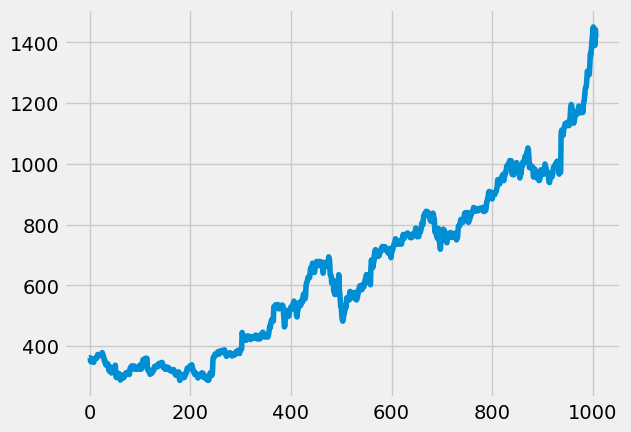

In [72]:
# Plot the timeseries
plt.plot(timeseries)
plt.show()

In [73]:
# Split the data into training and test sets
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [74]:
# Function to create the dataset
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [75]:
# Create the dataset
lookback = 10

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([795, 10, 1]) torch.Size([795, 10, 1])
torch.Size([192, 10, 1]) torch.Size([192, 10, 1])


In [76]:
# Define the model class
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [77]:
# Train the LSTM model
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_function(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_function(y_pred, y_test))

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 568.5861, test RMSE 1059.7849
Epoch 100: train RMSE 329.7408, test RMSE 794.4885
Epoch 200: train RMSE 153.1746, test RMSE 545.4081
Epoch 300: train RMSE 45.2552, test RMSE 334.0079
Epoch 400: train RMSE 18.6566, test RMSE 208.6300
Epoch 500: train RMSE 12.7125, test RMSE 159.9164
Epoch 600: train RMSE 11.9381, test RMSE 140.6591
Epoch 700: train RMSE 11.0947, test RMSE 129.0769
Epoch 800: train RMSE 10.2722, test RMSE 121.4141
Epoch 900: train RMSE 9.9494, test RMSE 121.5843
Epoch 1000: train RMSE 10.0912, test RMSE 114.4906
Epoch 1100: train RMSE 10.1812, test RMSE 113.8869
Epoch 1200: train RMSE 9.9529, test RMSE 109.0613
Epoch 1300: train RMSE 9.8731, test RMSE 116.4833
Epoch 1400: train RMSE 9.8392, test RMSE 107.4305
Epoch 1500: train RMSE 9.9968, test RMSE 105.7389
Epoch 1600: train RMSE 9.7591, test RMSE 112.2978
Epoch 1700: train RMSE 10.0011, test RMSE 109.2606
Epoch 1800: train RMSE 11.7118, test RMSE 116.3346
Epoch 1900: train RMSE 9.5600, test RMSE 115.

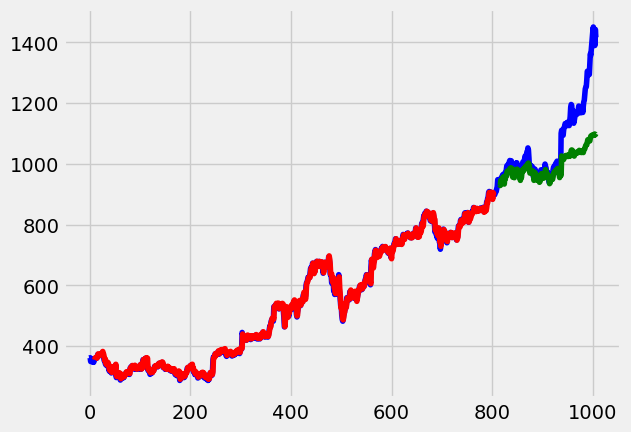

In [78]:
# Plot the results
with torch.no_grad():
    # Shift training predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# Plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [79]:
# Convert the numpy arrays to tensors
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

# Make predictions with the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor)[:, -1, :]
    y_test_pred = model(X_test_tensor)[:, -1, :]

# Flatten the predictions and actual values
y_train_pred_flat = y_train_pred.flatten()
y_test_pred_flat = y_test_pred.flatten()
y_train_flat = y_train_tensor[:, -1, :].flatten()
y_test_flat = y_test_tensor[:, -1, :].flatten()

In [80]:
# Calculate metrics
mse_train = mean_squared_error(y_train_flat, y_train_pred_flat)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_flat, y_train_pred_flat)
mape_train = mean_absolute_percentage_error(y_train_flat, y_train_pred_flat)

mse_test = mean_squared_error(y_test_flat, y_test_pred_flat)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_flat, y_test_pred_flat)
mape_test = mean_absolute_percentage_error(y_test_flat, y_test_pred_flat)

# Arrange metrics as a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE'],
    'Train': [mse_train, rmse_train, mae_train, mape_train],
    'Test': [mse_test, rmse_test, mae_test, mape_test]
})

metrics_df.set_index('Metric', inplace=True)
metrics_df

,Train,Test
Metric,,
MSE,88.51,12726.58
RMSE,9.41,112.81
MAE,6.41,71.72
MAPE,0.01,0.06


# Final Model Forecast

In [81]:
# Function to forecast future 'close' prices
def forecast_future(model, last_data, steps_ahead):
    model.eval()
    predictions = []
    input_seq = last_data.clone().detach()

    for _ in range(steps_ahead):
        with torch.no_grad():
            # Reshape input_seq
            input_seq_reshaped = input_seq.view(1, -1, 1)

            # Make prediction
            prediction = model(input_seq_reshaped)
            last_pred = prediction[0, -1, 0]

            # Append the prediction
            predictions.append(last_pred.item())

            # Update the input sequence with the new prediction
            input_seq = torch.roll(input_seq, -1, 0)
            input_seq[-1] = last_pred

    return predictions

In [82]:
# Last lookback data points from training
last_known_data = X_train_tensor[-lookback:]

# Number of future time steps to predict
future_steps = 30
future_predictions = forecast_future(model, last_known_data, future_steps)

In [83]:
# Create a DataFrame of the future predictions
future_df = pd.DataFrame({'close': future_predictions}, index=pd.date_range('2018-02-08', periods=30, freq='B'))
future_df

,close
2018-02-08,896.40
2018-02-09,894.82
2018-02-12,893.43
2018-02-13,892.21
2018-02-14,891.09
2018-02-15,890.09
2018-02-16,889.20
2018-02-19,888.43
2018-02-20,887.71
2018-02-21,886.99


In [84]:
# Load the original data
original_df = pd.read_csv('AMZN_data.csv', parse_dates=['date'], index_col=['date'])
original_df.drop(columns=['Name'], inplace=True)
original_df.tail()

,open,high,low,close,volume
date,,,,,
2018-02-01,1445.00,1459.88,1385.14,1390.00,9113808
2018-02-02,1477.39,1498.00,1414.00,1429.95,11125722
2018-02-05,1402.62,1458.98,1320.72,1390.00,11494985
2018-02-06,1361.46,1443.99,1351.79,1442.84,11066819
2018-02-07,1449.00,1460.99,1415.15,1416.78,7162741


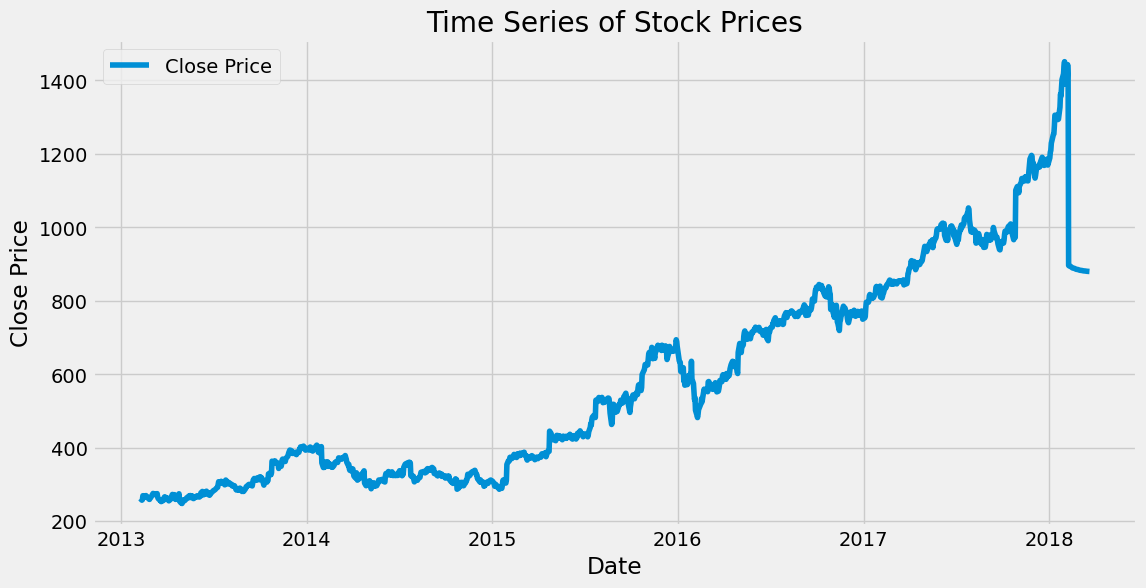

In [85]:
# Concatenate the original and future dataframes
combined_df = pd.concat([original_df, future_df])

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(combined_df['close'], label='Close Price')
plt.title('Time Series of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()